Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
import zipfile
import os
import cv2

import tarfile
import sys
import h5py
from six.moves import cPickle as pickle
from PIL import Image

%matplotlib inline

Algorithm to extract digitStruct File, since data cant be accessed with 'scipy.io' library

In [0]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references
#    input:              The input h5 matfile
#    digitStruct_name:   The h5 ref to all the file names
#    digitStruct_bbox:   The h5 ref to all struc data

class DigitStructFile:
    def __init__(self, input):
        self.input = h5py.File(input, 'r')
        self.digitStruct_name = self.input['digitStruct']['name']
        self.digitStruct_bbox = self.input['digitStruct']['bbox']

    # get_name returns the 'name' string for the n(th) digitStruct.

    def get_name(self,n):
        return ''.join([chr(c[0]) for c in self.input[self.digitStruct_name[n][0]].value])

    def bbox_helper(self,attribute):
        if (len(attribute) > 1):
            attribute = [self.input[attribute.value[j].item()].value[0][0] for j in range(len(attribute))]
        else:
            attribute = [attribute.value[0][0]]
        return attribute

    # get_bbox returns a 'dict' of data for the n(th) bbox.
    def get_bbox(self,n):
        bbox = {}
        bb = self.digitStruct_bbox[n].item()
        bbox['height'] = self.bbox_helper(self.input[bb]["height"])
        bbox['label']  = self.bbox_helper(self.input[bb]["label"])
        bbox['left']   = self.bbox_helper(self.input[bb]["left"])
        bbox['top']    = self.bbox_helper(self.input[bb]["top"])
        bbox['width']  = self.bbox_helper(self.input[bb]["width"])
        return bbox

    def get_DigitStructure(self,n):
        s = self.get_bbox(n)
        s['name']=self.get_name(n)
        return s

    # get_all_DigitStructure returns all the digitStruct from the input file.
    def get_all_DigitStructure(self):
        return [self.get_DigitStructure(i) for i in range(len(self.digitStruct_name))]
        
# Return a restructured version of the dataset (one structure by boxed digit).
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#      'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#      'left', 'top' : position of bounding box
#      'width', 'height' : dimension of bounding box

    def get_all_DigitStructure_ByDigit(self):
        img_data = self.get_all_DigitStructure()
        result = []
        struct_count = 1
        for i in range(len(img_data)):
            item = { 'filename' : img_data[i]["name"] }
            figures = []
            for j in range(len(img_data[i]['height'])):
                figure = {}
                figure['height'] = img_data[i]['height'][j]
                figure['label']  = img_data[i]['label'][j]
                figure['left']   = img_data[i]['left'][j]
                figure['top']    = img_data[i]['top'][j]
                figure['width']  = img_data[i]['width'][j]
                figures.append(figure)
            struct_count += 1
            item['boxes'] = figures
            result.append(item)
        return result


Reading of downloaded Train and Test dataset from drive

In [0]:
train_file = ('/content/drive/My Drive/SVHN/train.tar.gz')
test_file = ('/content/drive/My Drive/SVHN/test.tar.gz')

In [4]:
def extract_afile(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root):
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    print(data_folders)
    return data_folders
  
train_folders = extract_afile(train_file)
test_folders = extract_afile(test_file)


Extracting data for /content/drive/My Drive/SVHN/train. This may take a while. Please wait.
/content/drive/My Drive/SVHN/train
Extracting data for /content/drive/My Drive/SVHN/test. This may take a while. Please wait.
/content/drive/My Drive/SVHN/test


In [5]:
train_folders = 'train'
test_folders = 'test'

fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.get_all_DigitStructure_ByDigit()

print('Train ready')

fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.get_all_DigitStructure_ByDigit()

print('Test ready')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


Train ready
Test ready


Creating pickle dataset to write and read train and test data

In [0]:
pickle_file = 'train_data.pickle'

with open(pickle_file, 'wb') as f:
  pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)


pickle_file = 'test_data.pickle'

f = open(pickle_file, 'wb')
pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [0]:
train_folders = 'train'
test_folders = 'test'

pickle_name = 'train_data.pickle'

with open(pickle_name, 'rb') as f:
    train_data = pickle.load(f)
    
pickle_name = 'test_data.pickle'

with open(pickle_name, 'rb') as f:
    test_data = pickle.load(f)

Reading Image names from train data

In [0]:
img_names = []
for i in range(len(train_data)):
  img = train_data[i]['filename']
  img_names.append(img)

Reading Image names from test data

In [0]:
test_img_names = []
for i in range(len(test_data)):
  img = test_data[i]['filename']
  test_img_names.append(img)

Reading labels from Train data and assigning Label = '10' to '0'

In [10]:
train_labels = ['']*len(train_data)
for i in range(len(train_data)):
  for j in range(len(train_data[i]['boxes'])):
    if train_data[i]['boxes'][j]['label'] == float(10):
      train_data[i]['boxes'][j]['label'] = float(0)

    train_labels[i] += str(int(train_data[i]['boxes'][j]['label']))

print(train_labels)

['19', '23', '25', '93', '31', '33', '28', '744', '128', '16', '23', '63', '42', '58', '16', '23', '79', '53', '222', '62', '2', '515', '47', '89', '601', '24', '56', '52', '132', '14', '638', '43', '14', '42', '6', '44', '11', '17', '31', '20', '42', '251', '29', '204', '10', '327', '24', '46', '817', '103', '91', '35', '93', '11', '1137', '56', '215', '11', '2', '47', '5', '32', '43', '29', '58', '95', '10', '542', '44', '31', '2386', '15', '3', '33', '18', '98', '739', '138', '1922', '22', '74', '45', '60', '3', '17', '35', '17', '5', '18', '164', '193', '35', '17', '12', '1044', '18', '36', '120', '2', '109', '53', '35', '7', '104', '14', '14', '52', '2', '30', '63', '9', '187', '13', '19', '32', '513', '48', '3421', '323', '51', '1358', '17', '6', '5', '64', '108', '8', '13', '68', '4', '174', '98', '44', '9', '68', '2', '10', '46', '28', '9', '39', '4', '41', '195', '33', '2518', '15', '300', '47', '286', '33', '207', '19', '2', '7', '6', '57', '2', '91', '208', '85', '3', '560',

Reading labels from Test data and assigning Label = '10' to '0'

In [11]:
test_labels = ['']*len(test_data)
for i in range(len(test_data)):
  for j in range(len(test_data[i]['boxes'])):
    if test_data[i]['boxes'][j]['label'] == float(10):
      test_data[i]['boxes'][j]['label'] = float(0)

    test_labels[i] += str(int(test_data[i]['boxes'][j]['label']))

print(test_labels)

['5', '210', '6', '1', '9', '1', '183', '65', '144', '16', '34', '20', '13', '25', '4', '14', '28', '38', '60', '151', '129', '16', '9', '26', '1', '20', '69', '15', '19', '81', '51', '5', '29', '24', '10', '69', '32', '35', '1', '146', '28', '3', '14', '1712', '17', '10', '14', '46', '44', '28', '17', '74', '8', '23', '2', '23', '186', '376', '30', '72', '74', '288', '17', '19', '34', '2', '96', '260', '8', '20', '10', '32', '24', '67', '21', '35', '31', '59', '18', '12', '6', '46', '49', '36', '101', '25', '27', '52', '2', '14', '2', '9', '67', '102', '14', '83', '2', '16', '2', '61', '12', '36', '1', '1', '37', '23', '5', '6', '2', '10', '47', '10', '23', '73', '111', '20', '1', '71', '29', '1', '22', '9', '25', '76', '1', '14', '96', '27', '114', '17', '30', '36', '9', '40', '32', '31', '526', '18', '83', '39', '3', '76', '19', '10', '38', '23', '10', '19', '25', '5', '895', '9', '103', '21', '87', '1298', '6', '72', '9', '2', '15', '54', '53', '289', '36', '10', '8', '7', '22', '1

In [12]:
train_int_labels = []

for i in range(0,len(train_labels)):
    train_labels[i]=int(train_labels[i])
    train_int_labels.append(train_labels[i])
print(train_int_labels)

[19, 23, 25, 93, 31, 33, 28, 744, 128, 16, 23, 63, 42, 58, 16, 23, 79, 53, 222, 62, 2, 515, 47, 89, 601, 24, 56, 52, 132, 14, 638, 43, 14, 42, 6, 44, 11, 17, 31, 20, 42, 251, 29, 204, 10, 327, 24, 46, 817, 103, 91, 35, 93, 11, 1137, 56, 215, 11, 2, 47, 5, 32, 43, 29, 58, 95, 10, 542, 44, 31, 2386, 15, 3, 33, 18, 98, 739, 138, 1922, 22, 74, 45, 60, 3, 17, 35, 17, 5, 18, 164, 193, 35, 17, 12, 1044, 18, 36, 120, 2, 109, 53, 35, 7, 104, 14, 14, 52, 2, 30, 63, 9, 187, 13, 19, 32, 513, 48, 3421, 323, 51, 1358, 17, 6, 5, 64, 108, 8, 13, 68, 4, 174, 98, 44, 9, 68, 2, 10, 46, 28, 9, 39, 4, 41, 195, 33, 2518, 15, 300, 47, 286, 33, 207, 19, 2, 7, 6, 57, 2, 91, 208, 85, 3, 560, 5, 176, 754, 15, 282, 42, 76, 419, 21, 11, 59, 568, 5, 158, 21, 25, 1742, 37, 34, 21, 2800, 256, 130, 19, 45, 9, 26, 159, 3, 1, 43, 12, 1, 316, 297, 20, 318, 23, 105, 241, 4, 49, 49, 111, 9, 188, 26, 27, 29, 1, 8, 302, 280, 2, 18, 328, 51, 157, 2, 190, 68, 2, 136, 1, 111, 72, 3, 144, 10, 1358, 84, 210, 114, 193, 77, 140, 39

In [13]:
test_int_labels = []

for i in range(0,len(test_labels)):
    test_labels[i]=int(test_labels[i])
    test_int_labels.append(test_labels[i])
print(test_int_labels)

[5, 210, 6, 1, 9, 1, 183, 65, 144, 16, 34, 20, 13, 25, 4, 14, 28, 38, 60, 151, 129, 16, 9, 26, 1, 20, 69, 15, 19, 81, 51, 5, 29, 24, 10, 69, 32, 35, 1, 146, 28, 3, 14, 1712, 17, 10, 14, 46, 44, 28, 17, 74, 8, 23, 2, 23, 186, 376, 30, 72, 74, 288, 17, 19, 34, 2, 96, 260, 8, 20, 10, 32, 24, 67, 21, 35, 31, 59, 18, 12, 6, 46, 49, 36, 101, 25, 27, 52, 2, 14, 2, 9, 67, 102, 14, 83, 2, 16, 2, 61, 12, 36, 1, 1, 37, 23, 5, 6, 2, 10, 47, 10, 23, 73, 111, 20, 1, 71, 29, 1, 22, 9, 25, 76, 1, 14, 96, 27, 114, 17, 30, 36, 9, 40, 32, 31, 526, 18, 83, 39, 3, 76, 19, 10, 38, 23, 10, 19, 25, 5, 895, 9, 103, 21, 87, 1298, 6, 72, 9, 2, 15, 54, 53, 289, 36, 10, 8, 7, 22, 14, 26, 16, 6, 50, 26, 41, 29, 21, 3, 79, 44, 569, 62, 36, 2, 99, 4, 25, 16, 147, 72, 6, 6, 9, 20, 216, 96, 24, 2, 56, 30, 67, 48, 2, 10, 74, 4, 21, 24, 9, 16, 75, 89, 9, 63, 3, 25, 12, 12, 66, 26, 5, 31, 28, 42, 348, 43, 14, 14, 17, 587, 1045, 47, 9, 31, 24, 27, 139, 18, 27, 17, 35, 322, 67, 49, 34, 3, 342, 2, 12, 1, 27, 23, 33, 11, 4, 3

Reading a sample image from train dataset with size (256,256)

In [0]:
img = cv2.imread('/content/train/749.png')
#img = img.astype(int)
img = cv2.resize(img,(256,256))

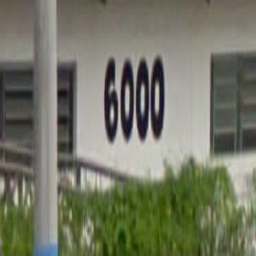

In [15]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

Reading all train images and append it to variable 'X'

In [0]:
images_name = img_names
X = []
#Y = []
for i in range(len(images_name)):
  try:
    #print('/content/train/'+ images_name[i])
    img = cv2.imread('/content/train/'+ images_name[i])
    #img = np.array(img)[indices.astype(int)]
    img = cv2.resize(img,(256,256))
    #print(img)
    #y = digit_struct['digitStruct']['bbox'][i]['label']
    X.append(img)
    #Y.append(y)
  except:
    print("Unable to do")
    pass

Reading all train labels and append it to variable 'Y'

In [0]:
Y = train_int_labels

Converting labels list to an array

In [18]:
Y = np.array(Y)
Y.shape

(33402,)

Converting image list to an array

In [0]:
X = np.array(X)
X.shape

Normalization of features

In [0]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

Splitting Train dataset into training and testing dataset

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Building model with Sequential method

In [0]:
model = Sequential()

Adding Convolution layers to create Neural Network

((((Conv2D, ReLu)x 2 -> MaxPooling2D)x 2) -> Dropout)x 2) -> (Flatten) -> ((Dense, Dropout,BatchNormalization)x 2) -> (Dense, Softmax)

In [0]:
model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(rate=0.2))

In [0]:
model.add(Flatten())

In [0]:
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Dense(units=10, activation='softmax'))

In [0]:
model.summary()

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(x=X_train, y=y_train, batch_size=200, epochs=10, validation_data=(X_test, y_test))

In [0]:
model.save(filepath="/content/drive/My Drive/SVHN/SVHN_1st_format.h5")